
# <center>Predicting the returns of orders  for a retail shoe seller</center>




###  Challenge SD210 2018
#### Authors : Aziz Rachdi, Benjamin Fargeton, Matthis Maillard, Antoine Prat

In [1]:
from __future__ import division
import os
import sys
from importlib import reload
reload(sys)
#sys.setdefaultencoding("utf-8")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

## Loading the data

In [3]:
customers = pd.read_csv("customers2.csv")
# Importing products (more complicated since it contains errors)

products = pd.read_csv("products2.csv", sep = ";", encoding = 'iso-8859-1') # encoding in utf-8 produces errors
products.VariantId = products.VariantId.apply(pd.to_numeric, errors = 'coerce') # removes VariantId which are strings
products = products.dropna(subset=['VariantId'])
products = products[products.VariantId > 100] # removes wrong VariantId (VariantId < 100 are errors)
products.VariantId= products.VariantId.astype(int)

X_train = pd.read_csv("X_train.csv")
X_test   = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")

/Users/matthis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Visualizing the data

## X_train

/Users/matthis/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


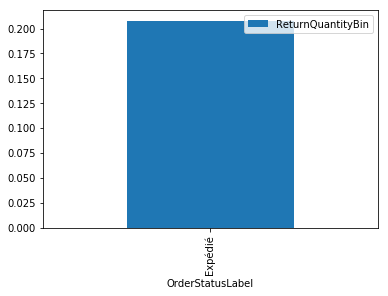

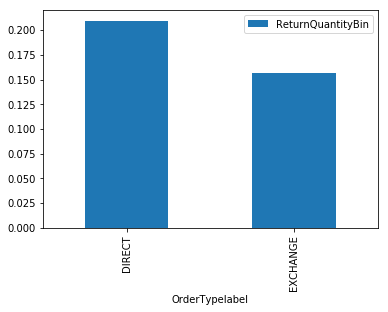

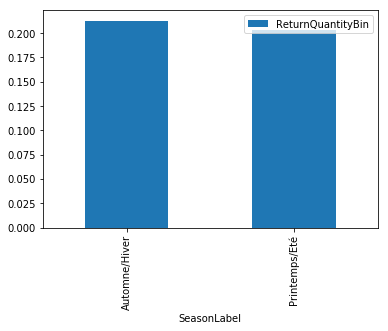

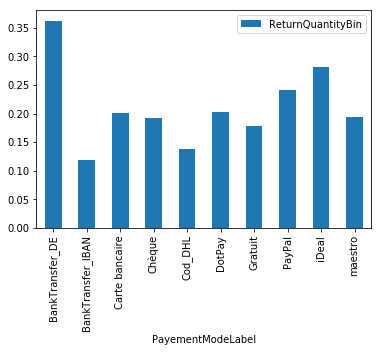

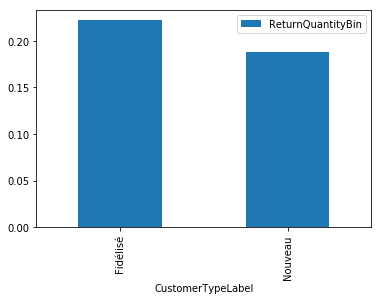

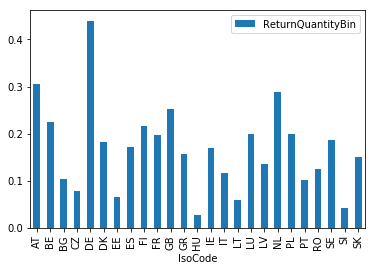

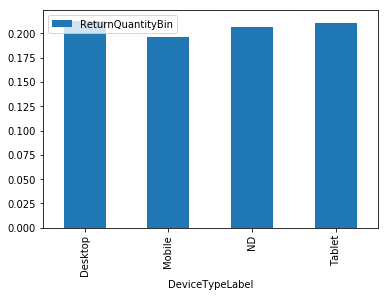

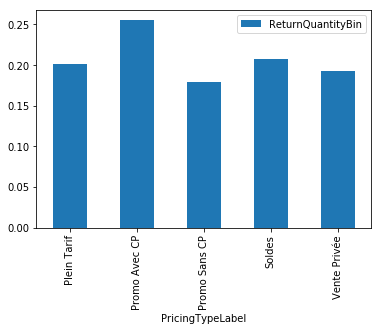

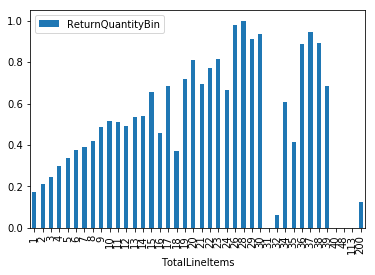

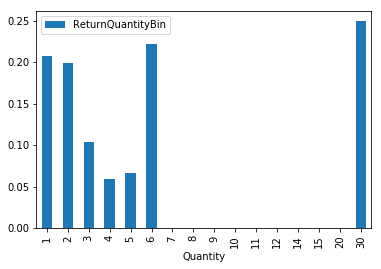

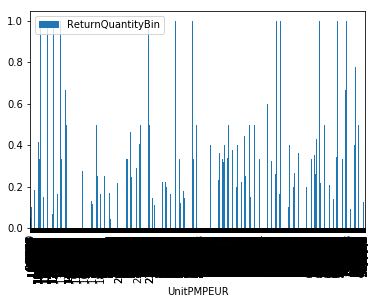

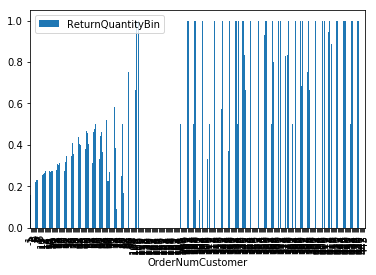

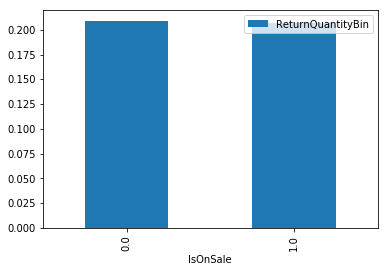

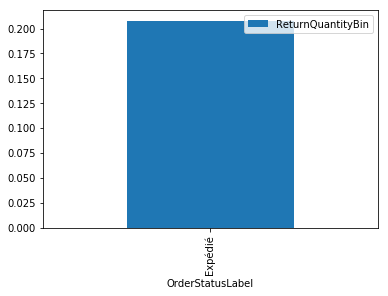

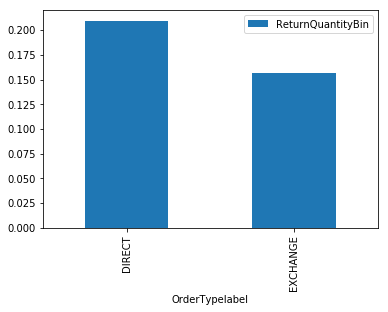

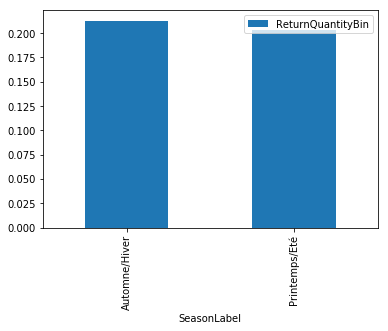

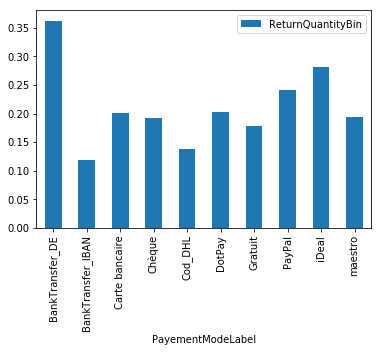

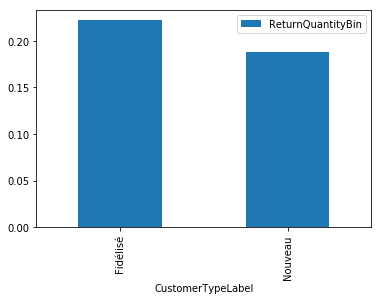

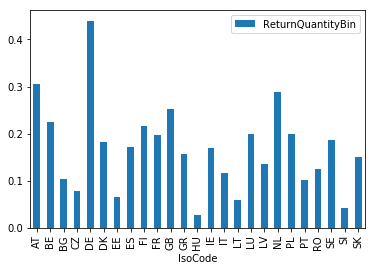

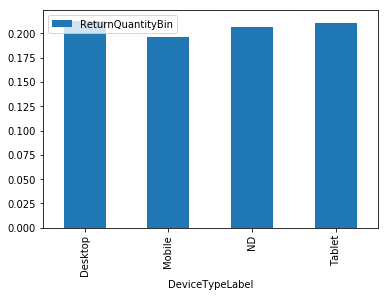

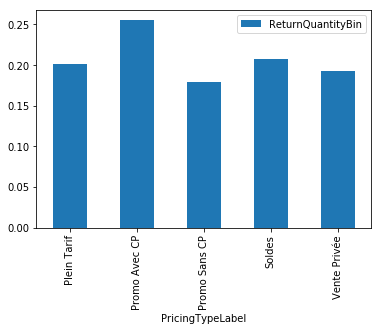

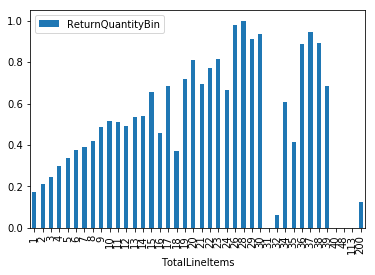

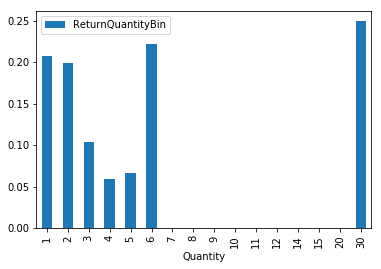

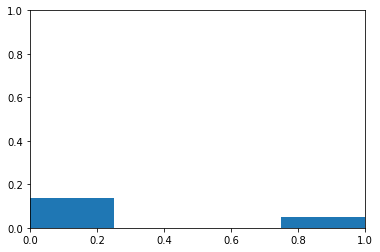

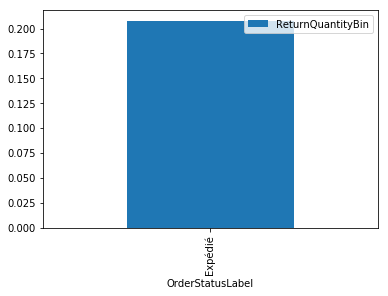

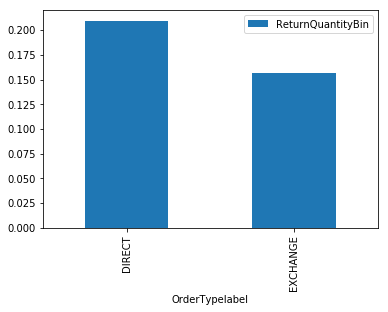

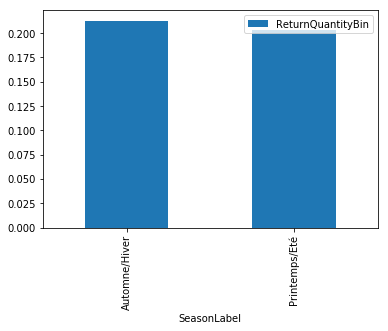

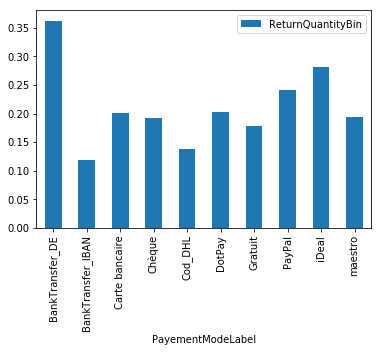

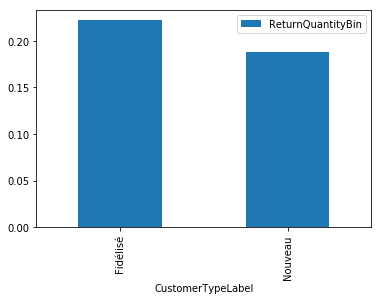

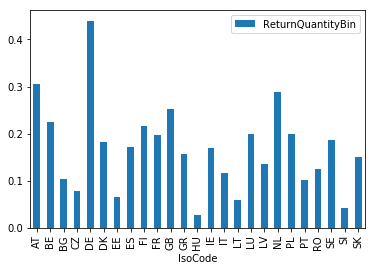

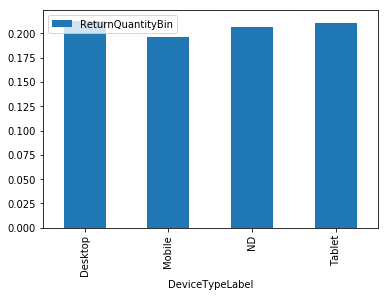

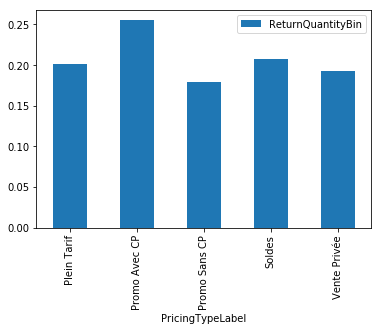

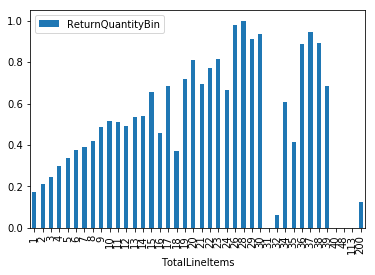

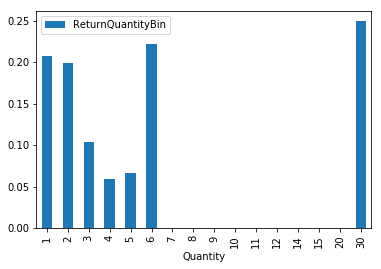

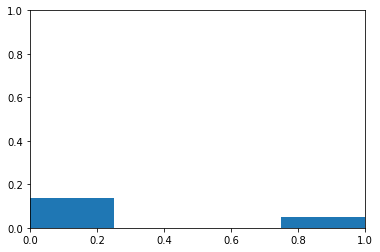

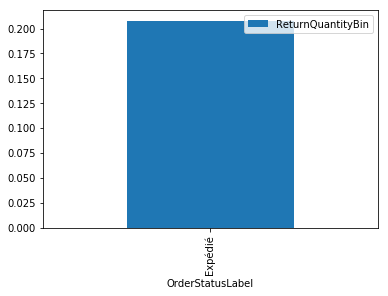

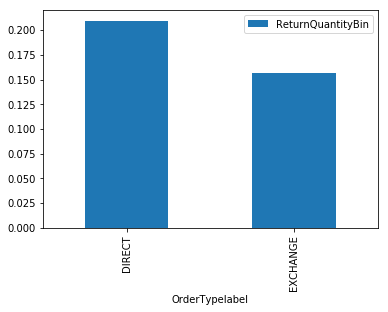

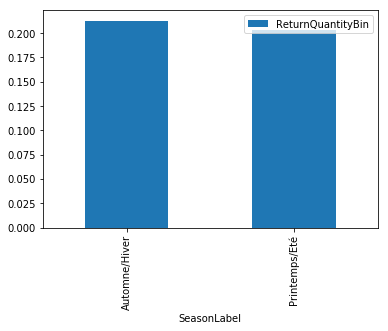

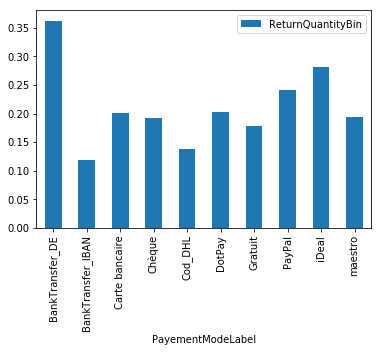

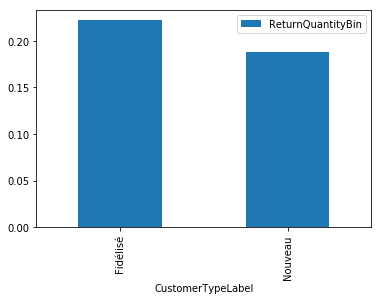

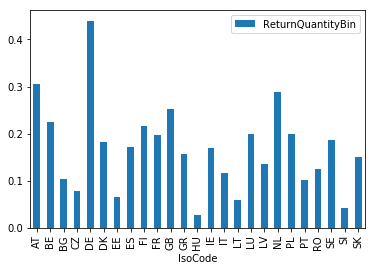

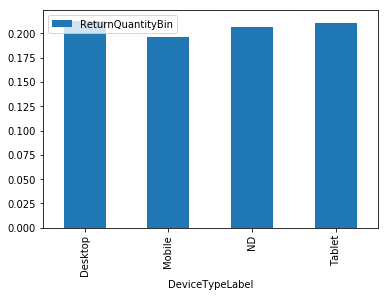

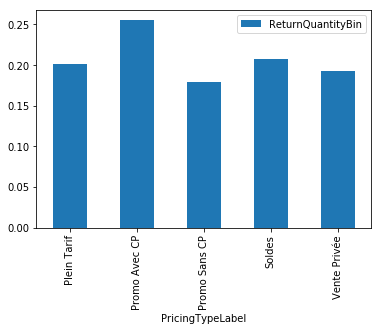

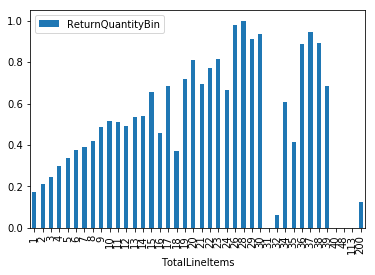

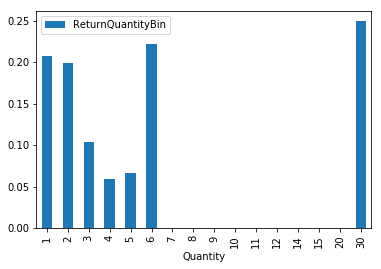

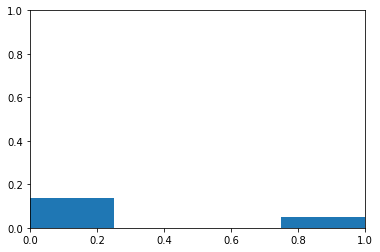

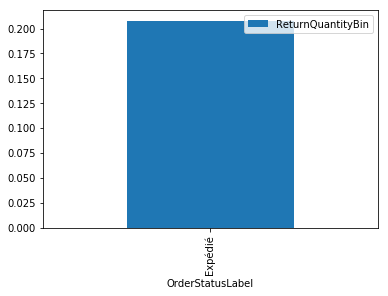

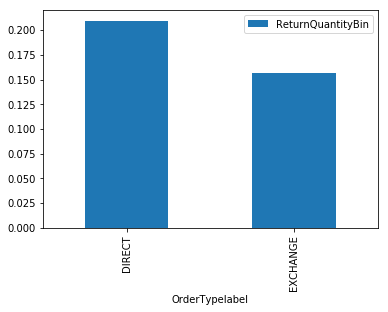

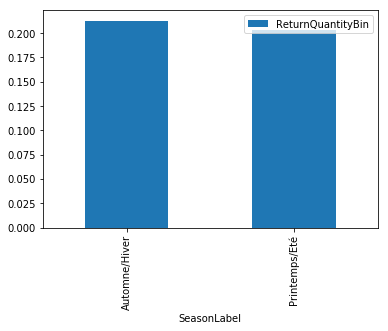

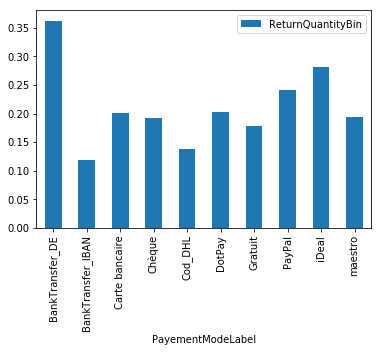

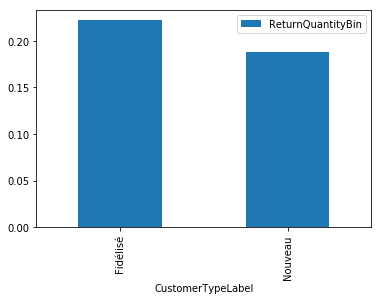

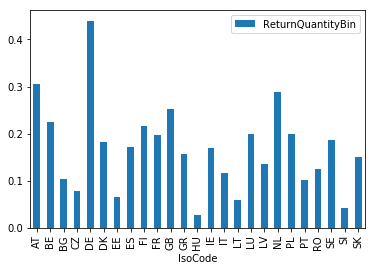

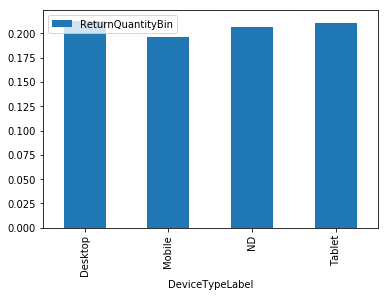

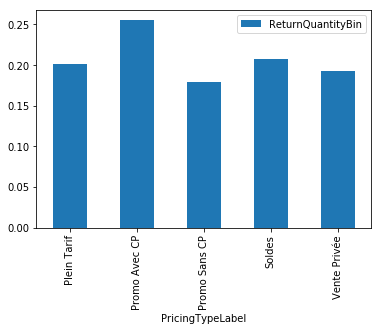

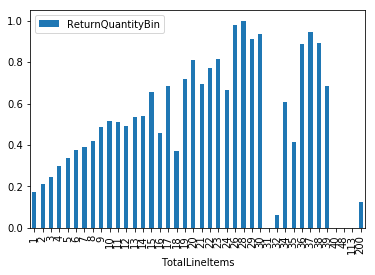

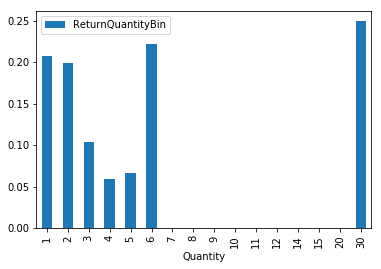

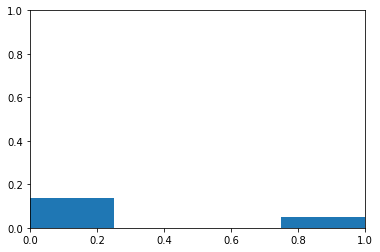

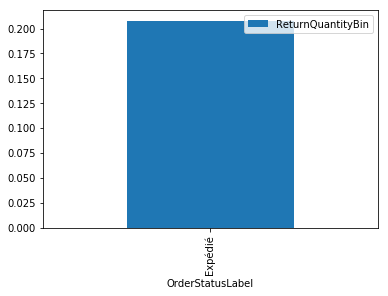

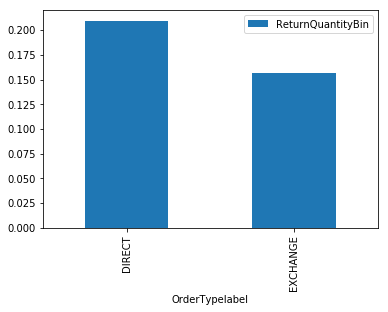

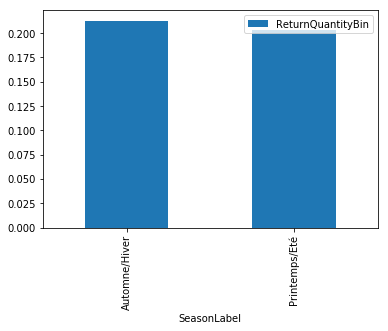

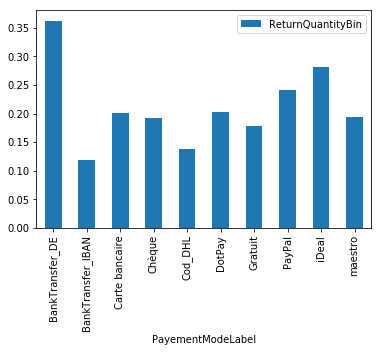

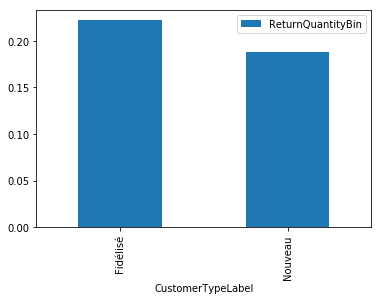

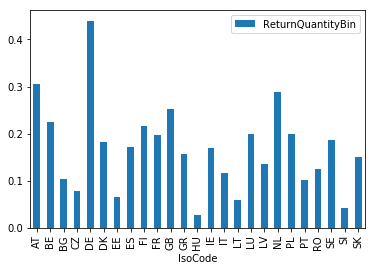

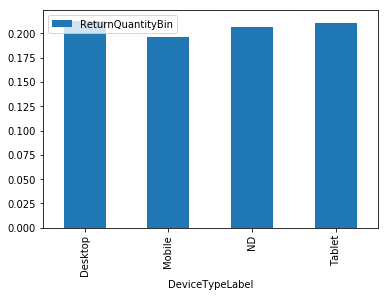

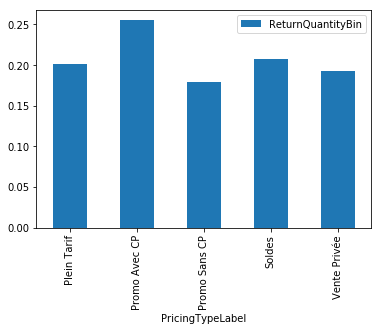

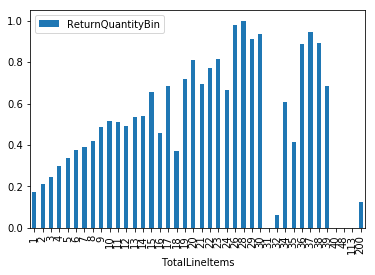

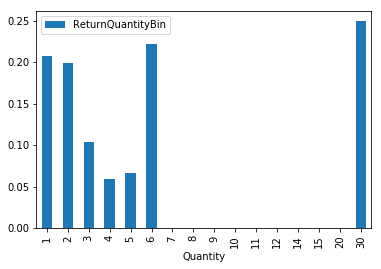

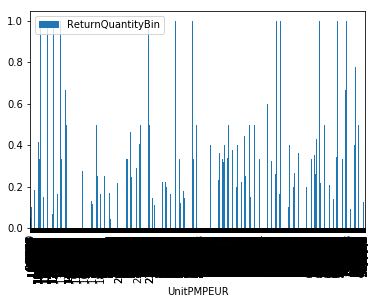

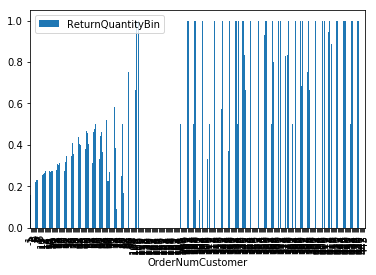

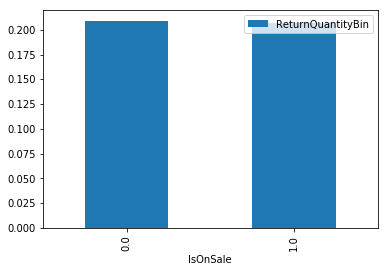

In [11]:
X0 = pd.merge(X_train, y_train, on=['OrderNumber', 'LineItem'])

columns = ['OrderStatusLabel', 'OrderTypelabel', 'SeasonLabel',
       'PayementModeLabel', 'CustomerTypeLabel', 'IsoCode', 'DeviceTypeLabel',
       'PricingTypeLabel', 'TotalLineItems', 'Quantity', 'UnitPMPEUR', 'OrderNumCustomer', 'IsOnSale']

for carac in columns:
    plt.figure()
    # on ne sélectionne la colonne des retours et carac
    join = X0[['ReturnQuantityBin', carac]]
    #on calcule le nombre de retours par valeur divisé par le nombre de commandes ayant cette valeur
    join = join.groupby(carac).sum()/join.groupby(carac).count()
    #on affiche les pourcentages obtenus
    join.plot(kind ='bar')
    plt.show()

## Products

In [3]:
def add_universe_products(X,y,carac):
    #On crée la table Customer + X_train pour avoir accès à la BirthDate et OrderCreationDate
    right= products.loc[:,['VariantId',carac]]
    right = right.set_index('VariantId')
    # fusion de la table X avec la table right qui est une sous table de product
    result = pd.merge(X, right, left_on='VariantId', right_index=True, how="left", sort=False)
    # fusion de la table précédemment obtenue avec y qui contient la colonne des retours
    result = pd.merge(result, y, on=['OrderNumber', 'LineItem'])
    return (result)

In [4]:
# liste des colonnes que l'on voudrait tester
columns = ['GenderLabel', 'MarketTargetLabel', 'SeasonalityLabel', 'UniverseLabel', 'TypeBrand', 
           'ProductType', 'SupplierColor', 'MinSize', 'MaxSize', 'CalfTurn', 'UpperHeight', 'HeelHeight', 
           'PurchasePriceHT', 'IsNewCollection', 'SubtypeLabel', 'UpperMaterialLabel', 'LiningMaterialLabel',
          'OutSoleMaterialLabel', 'RemovableSole', 'SizeAdviceDescription']
# liste des colonnes dont le nombre de valeurs possibles est inférieur à 40
small_columns = [elt for elt in columns if len(products[elt].unique())<=40]
long_columns = [elt for elt in columns if elt not in small_columns]

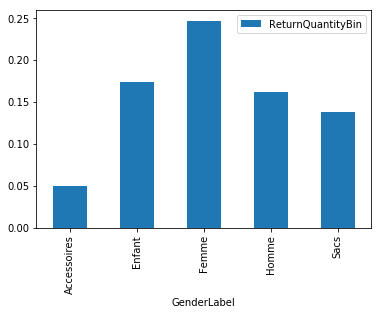

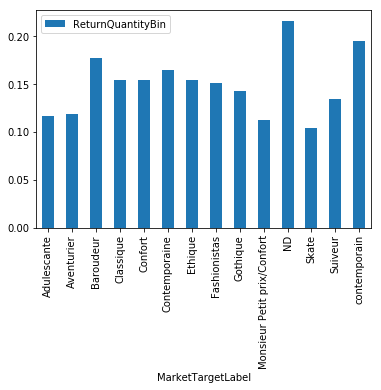

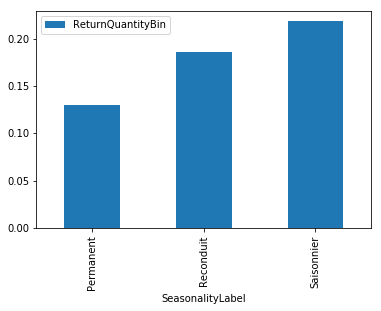

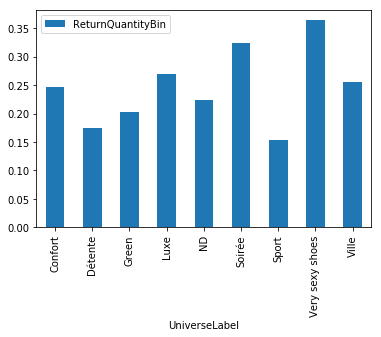

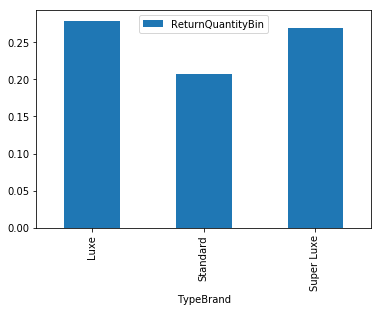

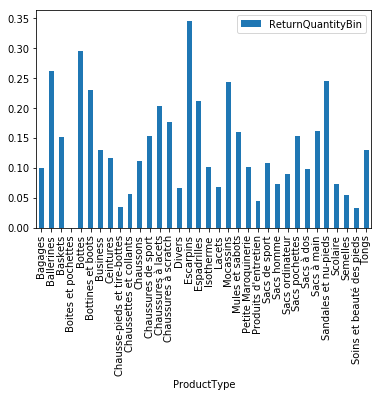

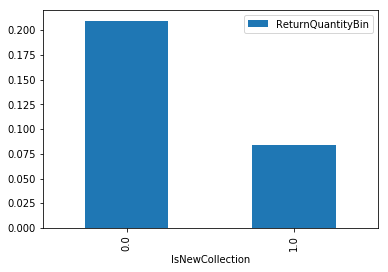

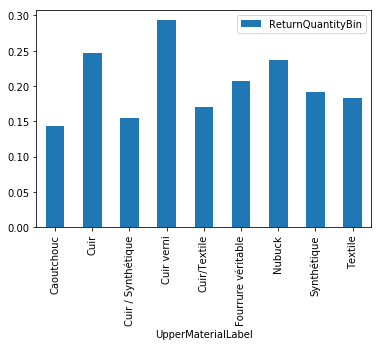

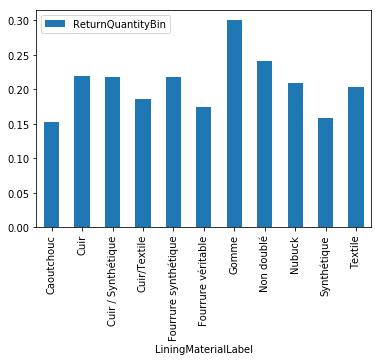

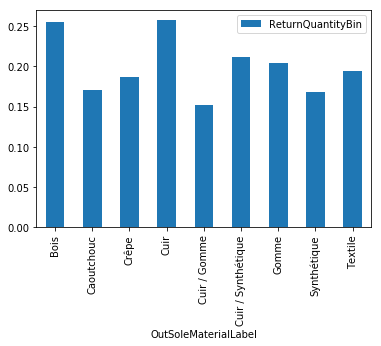

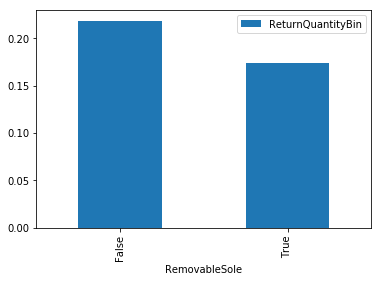

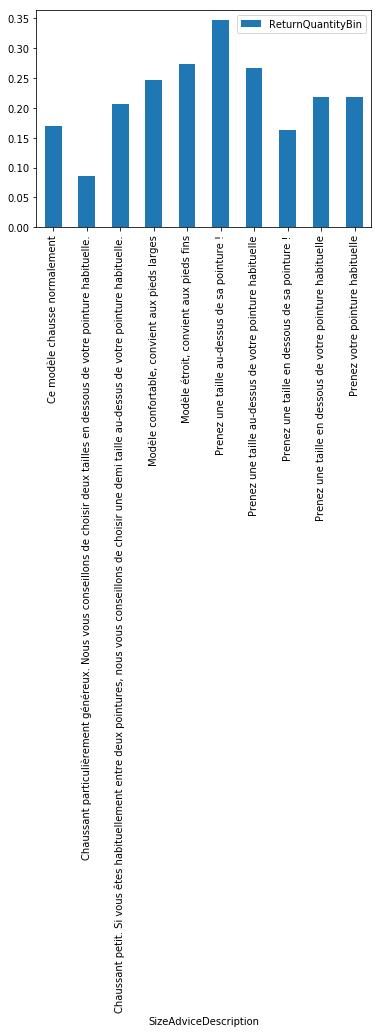

In [5]:
for carac in columns:
    # on fusionne X_train avec y_train et la colonne de products carac
    X0=add_universe_products(X_train, y_train,carac)
    # on ne sélectionne la colonne des retours et carac
    join = X0[['ReturnQuantityBin', carac]]
    #on calcule le nombre de retours par valeur divisé par le nombre de commandes ayant cette valeur
    join = join.groupby(carac).sum()/join.groupby(carac).count()
    #on affiche les pourcentages obtenus
    join.plot(kind ='bar')

## Order Table

## Defining a feature transformation

Nous avons préféré ajouter unes à unes les nouvelles caractéristiques à X_train et X_test par un soucis de clareté. Cette façon de fonctioner est plus couteuse en temps mais cela nous permet de voir facilement lesquelles nous ajoutons. 

In [6]:
# Fonction pour ajouter le sexe du client dans la base de donnée order (X_train et X_test)
def add_gender(d):
    right = customers.loc[:,['CustomerId','Gender']]
    right = right.set_index('CustomerId')
    d = pd.merge(d , right, left_on = 'CustomerId', right_index=True ,how='left', sort = False)
    return(d)
        

In [7]:
def add_Product_Type(d):
    right = products.loc[:,['VariantId','ProductType']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [8]:
def add_IsNewCollection(d):
    right = products.loc[:,['VariantId','IsNewCollection']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [9]:
def add_UpperMaterialLabel(d):
    right = products.loc[:,['VariantId','UpperMaterialLabel']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [10]:
def add_gender_label(d):
    right = products.loc[:,['VariantId','GenderLabel']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [58]:
def add_brand_id(d):
    right = products.loc[:,['VariantId','BrandId']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

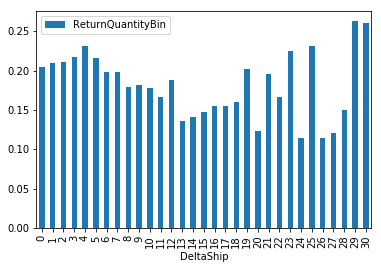

In [21]:
# On calcule l'écart en jours entre la date de commande et la date d'expédition
def add_deltaship(d):
    order_date = pd.to_datetime(d['OrderCreationDate'])
    ship_date = pd.to_datetime(d['OrderShipDate'])
    delta = ship_date - order_date
    delta = pd.to_datetime(delta).dt.day -1
    return (d.assign(DeltaShip = delta))

test = add_deltaship(X_train)
test = pd.merge(test, y_train, on=['OrderNumber', 'LineItem'])
join = test[['ReturnQuantityBin', 'DeltaShip']]
join = join.groupby('DeltaShip').sum()/join.groupby('DeltaShip').count()
join.plot(kind ='bar')

In [12]:
# On ajoute l'age du client
# on a choisis deux possibilité : soit on retourne une classe d'age, soit on retourne l'age
def add_age(d):
    right = customers.loc[:,['CustomerId','BirthDate']]
    right = right.set_index('CustomerId')
    merged = pd.merge(d , right, left_on = 'CustomerId', right_index=True ,how='left', sort = False)
    order_date = pd.to_datetime(merged['OrderCreationDate'])
    merged=merged.drop(merged.loc[lambda df: df.BirthDate > str(2016), :].index)
    birth_date = pd.to_datetime(merged['BirthDate'])
    age = order_date - birth_date
    age = age.dt.days/365.25
    
    age_final = (age<14)*1
    age_final += (age<20)*1
    age_final += (age<30)*1
    age_final += (age<40)*1
    age_final += (age<60)*1
    age_final += (age<90)*1
    age_final -= (age<5)*6
    
    return (d.assign(CustomerAge = age))

In [13]:
def add_size_advice(d):
    right = products.loc[:,['VariantId','SizeAdviceDescription']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [14]:
# on ajoute l'heure de la commande
def add_order_hour(d):
    return d.assign(TimeDay = pd.DataFrame(pd.to_datetime(X_train['OrderCreationDate']).dt.hour))

In [15]:
def add_subtype_label(d):
    right = products.loc[:,['VariantId','SubtypeLabel']]
    right = right.set_index('VariantId')
    d = pd.merge(d , right, left_on = 'VariantId', right_index=True ,how='left', sort = False)
    return(d)

In [54]:
# on calcule si la date de commande corresond à la saison de l'objet
def add_is_same_season(d):
    right = products.loc[:,['VariantId','SeasonLabel']]
    right = right.set_index('VariantId')
    merged = pd.merge(d.loc[:,['VariantId', 'OrderShipDate']] , right, left_on = 'VariantId', 
                      right_index=True ,how='left', sort = False)
    merged.OrderShipDate = pd.to_datetime(merged.OrderShipDate).dt.month
    hiver = (merged.OrderShipDate > 9)*1 + (merged.OrderShipDate < 4)*1
    same_season = (hiver.astype(bool) == (merged.SeasonLabel == 'Automne/Hiver'))
    d = d.assign(SameSeason = same_season*1)
    return(d)

# Applying our features

In [ ]:
t1 = add_gender(X_train)
t1 = add_Product_Type(t1)
t1 = add_IsNewCollection(t1)
t1 = add_UpperMaterialLabel(t1)
t1 = add_gender_label(t1)
t1 = add_deltaship(t1)
t1 = add_age(t1)
t1 = add_size_advice(t1)
t1 = add_order_hour(t1)
t1 = add_subtype_label(t1)
t1 = add_is_same_season(t1)
t1 = add_brand_id(t1)

t2 = add_gender(X_test)
t2 = add_Product_Type(t2)
t2 = add_IsNewCollection(t2)
t2 = add_UpperMaterialLabel(t2)
t2 = add_gender_label(t2)
t2 = add_deltaship(t2)
t2 = add_age(t2)
t2 = add_size_advice(t2)
t2 = add_order_hour(t2)
t2 = add_subtype_label(t2)
t2 = add_is_same_season(t2)
t2 = add_brand_id(t2)

In [110]:
def pivot(d,feat):
    temp = pd.merge(d, y_train, on=['OrderNumber', 'LineItem'])
    pivot = temp[[feat, 'ReturnQuantityBin']].groupby([feat], as_index=False).agg(['mean', 'count'])
    return pivot.sort_values(by=[('ReturnQuantityBin','mean')], ascending=True)

# Dictionary from pivot
def dict_from_pivot(rate):
    return dict(zip(np.array(rate.index.values),np.arange(1,int(len(rate))+1)))

# Converting BrandId, #t1 is X_train with all the new features
pvtBrand = pivot(t1,'BrandId')
pvtBrand = pvtBrand[(pvtBrand['ReturnQuantityBin','count'] >= 1000)]
convert_BrandId = dict(zip(np.insert(np.array(pvtBrand.index.values),0,0),np.arange(0,int(len(pvtBrand)))))
#t2 is X_test with all the new features
t2['BrandId'] = t2['BrandId'].map(convert_BrandId)

## Applying the mask

In [12]:
def funk_mask(d):
    " Defining a simple mask over the input data "
    columns_ext = ["OrderCreationDate","OrderNumber","VariantId", "CustomerId","OrderCreationDate","OrderShipDate","BillingPostalCode"]
    
    X1 = d.loc[:,[xx for xx in d.columns if xx not in columns_ext]]
    #on remplace les , par des . dans notre UnitPMPEur pour pouvoir créer une feature linéaire.
    g = lambda x: x.replace(",",".")
    X1.UnitPMPEUR = map(np.float64,(map(g,X1.UnitPMPEUR)))
    
    columns2bin = [x for x in X1.columns if X1[x].dtype == np.dtype('O')]
    
    X2 = pd.get_dummies(X1.loc[:,columns2bin])
    X1 = X1.loc[:,[xx for xx in X1.columns if xx not in columns2bin]]
    for xx in X1.columns:
        X1[xx] = X1[xx].fillna(X1[xx].mean())
    res = pd.concat([X1,X2],axis=1)
    return(res)

In [ ]:
x1 = funk_mask(t1)
x2 = funk_mask(t2)
seleckt_columns = np.intersect1d(x1.columns,x2.columns)
x1 = x1.loc[:,seleckt_columns]
x2 = x2.loc[:,seleckt_columns]


## Supervised learning : Logistic Regression

In [ ]:
logistic = LogisticRegression(fit_intercept = False)

Cs =[0.01, 0.1, 1, 10 ] 
n_components = [80, 100, 120, 160]
pipe = Pipeline(steps=[('pca', PCA()), ('logistic', logistic)])

stds = StandardScaler()
estimators = GridSearchCV(pipe, dict(pca__n_components = n_components, logistic__C =Cs ), scoring = make_scorer(roc_auc_score), verbose=True)
estimators.fit(stds.fit_transform(x1_train), y1_train)
print("Params :",estimators.best_params)
print("Score :",estimators.best_score)
y_tosubmit = estimators.predict_proba(stds.transform(x1_test))

print(roc_auc_score(y1_test, y_tosubmit[:,1]))


## Supervised learning : XGBoost

In [113]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [ ]:
stds = StandardScaler()
x1_scaled = stds.fit_transform(x1)

In [ ]:
model = XGBClassifier(booster = 'gbtree', learning_rate= 0.1, n_estimators=300,
                     objective = 'binary:logistic', silent = False,
                     alpha=2.2566, colsample_bytree = 0.7527, reg_gamma = 2.3014,
                      max_depth = 5, min_child_weight=17.1129, subsample = 0.7853)
model.fit(x1_scaled, y_train.ReturnQuantityBin)
y_tosubmit = model.predict_proba(stds.transform(x2))
np.savetxt('y_pred.txt', y_tosubmit[:,1], fmt='%f') #bestscore

## Supervised learning : Bagging of MLP Classifier

### CVGridSearch of one mlp

In [ ]:
mlp = MLPClassifier()

estimators = GridSearchCV(mlp, param_grid = {'alpha':[1e-4, 1e-3, 1e-2, 1e-1]}, scoring = make_scorer(roc_auc_score), verbose=True)
estimators.fit(x1, y_train.ReturnQuantityBin)
y_tosubmit = estimators.predict_proba(x2)
np.savetxt('y_pred.txt', y_tosubmit[:,1], fmt='%f')

In [ ]:
mlp = MLPClassifier(alpha=1e-2)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y_train.ReturnQuantityBin)

bag = BaggingClassifier(mlp, n_estimators = 40, max_samples=0.3, max_features=0.6, verbose = True)
bag.fit(x1_train, y_train.ReturnQuantityBin)
y_pred = bag.predict_proba(x1_test)
print("score :", roc_auc_score(y1_test, y_pred[:,1]))

y_tosubmit = bag.predict_proba(x2)
np.savetxt('y_pred.txt', y_tosubmit[:,1], fmt='%f')